## Data Collection

### Downloading Datasets from Kaggle

In [30]:
! pip install kaggle

In [31]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [32]:
! cp kaggle.json ~/.kaggle/

In [33]:
! chmod 600 ~/.kaggle/kaggle.json

In [34]:
! kaggle datasets download moltean/fruits

 99% 1.27G/1.28G [00:09<00:00, 216MB/s]
100% 1.28G/1.28G [00:09<00:00, 146MB/s]


### Importing Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import pathlib
import PIL
import tensorflow as tf
from PIL import Image

### Unzipping the files

In [36]:
!unzip fruits.zip


Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

## Pre Processing


### Adding Paths

In [37]:
train_path = pathlib.Path("/content/fruits-360_dataset/fruits-360/Training")
test_path = pathlib.Path("/content/fruits-360_dataset/fruits-360/Test")

In [38]:
image_count = len(list(train_path.glob("*/*.jpg")))
image_count

67692

### Declaring Variables

In [39]:
batch_size = 100
image_width = 100
image_height = 100
random_state = 100

### Importing data

In [40]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.25,
    subset = "training",
    seed = random_state,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 67692 files belonging to 131 classes.
Using 50769 files for training.


In [41]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.25,
    subset = "validation",
    seed = random_state,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 67692 files belonging to 131 classes.
Using 16923 files for validation.


In [42]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 22688 files belonging to 131 classes.


In [43]:
class_names = train_data.class_names
class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

## Defining Model

In [44]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)]
)

In [45]:
preprocess=tf.keras.applications.vgg16.preprocess_input

In [46]:
base_model = tf.keras.applications.vgg16.VGG16(
    input_shape = (image_height, image_width, 3),
    include_top = False,
    weights = "imagenet"
)

58900480/58889256 [==============================] - 0s 0us/step


In [47]:
base_model.trainable = False

In [48]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

## Compiling Model

In [49]:
inputs = tf.keras.Input((100, 100, 3))
mdl = data_augmentation(inputs)
mdl = preprocess(mdl)
mdl = base_model(mdl, training = False)
mdl = global_average_layer(mdl)
mdl= tf.keras.layers.Dropout(0.3)(mdl)
outputs = prediction_layer(mdl)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"]
)

## Training the Model

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)
history = model.fit(train_data, validation_data = validation_data, batch_size = 100, epochs = 99999999, callbacks=[early_stopping])

Epoch 1/99999999
508/508 [==============================] - 195s 383ms/step - loss: 6.3662 - accuracy: 0.9565 - val_loss: 1.6546 - val_accuracy: 0.9811
Epoch 2/99999999
508/508 [==============================] - 195s 383ms/step - loss: 6.3079 - accuracy: 0.9573 - val_loss: 1.5763 - val_accuracy: 0.9839
Epoch 3/99999999
508/508 [==============================] - 195s 384ms/step - loss: 6.1428 - accuracy: 0.9582 - val_loss: 1.2364 - val_accuracy: 0.9855
Epoch 4/99999999
508/508 [==============================] - 195s 383ms/step - loss: 6.4648 - accuracy: 0.9595 - val_loss: 1.6260 - val_accuracy: 0.9846
Epoch 5/99999999
508/508 [==============================] - 195s 383ms/step - loss: 6.6842 - accuracy: 0.9591 - val_loss: 1.0321 - val_accuracy: 0.9870
Epoch 6/99999999
508/508 [==============================] - 195s 383ms/step - loss: 6.5134 - accuracy: 0.9597 - val_loss: 1.4473 - val_accuracy: 0.9871
Epoch 7/99999999
508/508 [==============================] - 195s 383ms/step - loss: 6.04

In [52]:
model.evaluate(test_data)

227/227 [==============================] - 68s 298ms/step - loss: 21.9796 - accuracy: 0.9452


[21.979551315307617, 0.9451692700386047]

##Results

In [53]:
def predict_fruit(img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  PRED = model.predict(img_array)
  PRED = np.argmax(PRED[0])
  return class_names[PRED]

In [54]:
def get_image_from_path(address):
  img = Image.open(address)
  plt.imshow(img)
  plt.show()
  return img

In [55]:
def predict():
  address = input("Enter image path: ")

  img = get_image_from_path(address)

  print(predict_fruit(img))

Enter image path: /content/fruits-360_dataset/fruits-360/Test/Avocado/48_100.jpg


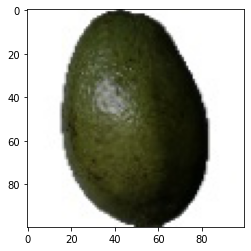

Avocado


In [56]:
predict()

Enter image path: /content/fruits-360_dataset/fruits-360/Test/Apple Golden 2/33_100.jpg


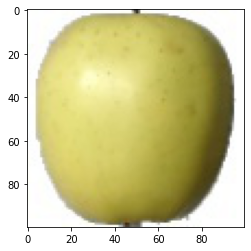

Apple Golden 2


In [57]:
predict()

Enter image path: /content/fruits-360_dataset/fruits-360/Test/Guava/102_100.jpg


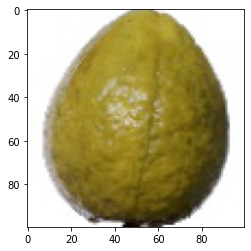

Guava


In [58]:
predict()